In [1]:
from scipy.io.wavfile import read as wavread
fs, x_int16 = wavread('lisa.wav')
x = x_int16 / (2 ** 15 - 1)

C:\Users\a1989\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
from world import main
vocoder = main.World()
# analysis
dat = vocoder.encode(fs, x, f0_method='harvest')

ModuleNotFoundError: No module named 'world'

In [8]:
import pyworld as pw
_f0, t = pw.dio(x, fs)    # raw pitch extractor
f0 = pw.stonemask(x, _f0, t, fs)  # pitch refinement
sp = pw.cheaptrick(x, f0, t, fs)  # extract smoothed spectrogram
ap = pw.d4c(x, f0, t, fs)         # extract aperiodicity
y = pw.synthesize(f0, sp, ap, fs)

In [97]:
from obspy.imaging.spectrogram import spectrogram
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

#make time vector
t = np.arange(spl1[0].stats.npts) / spl1[0].stats.sampling_rate

#plot waveform (top subfigure)    
ax1.plot(t, spl1[0].data, 'k')

#plot spectrogram (bottom subfigure)
spl2 = spl1[0]
fig = spl2.spectrogram(show=False, axes=ax2)
mappable = ax2.images[0]
plt.colorbar(mappable=mappable, cax=ax3)

ModuleNotFoundError: No module named 'obspy'

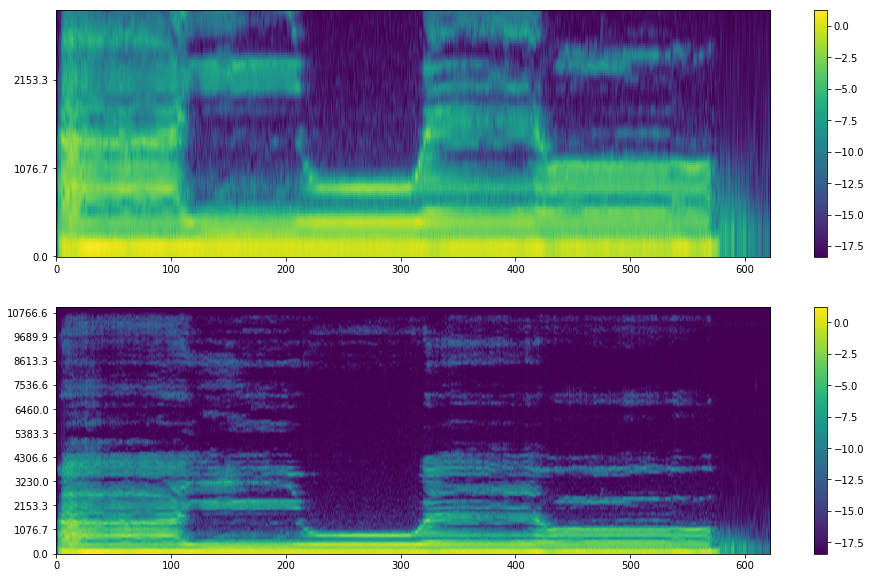

Please check "test" directory for output files


<Figure size 432x288 with 0 Axes>

In [8]:
from __future__ import division, print_function

import os
from shutil import rmtree
import argparse

import numpy as np

import matplotlib      # Remove this line if you don't need them
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import soundfile as sf
# import librosa
import pyworld as pw


EPSILON = 1e-8
wavname = 'aiueo_l'
x, fs = sf.read(wavname+'.wav')

def savefig(figlist, log=True):
    #h = 10
    n = len(figlist)
    # peek into instances
    f = figlist[0]
    if len(f.shape) == 1:
        plt.figure()
        for i, f in enumerate(figlist):
            plt.subplot(n, 1, i+1)
            if len(f.shape) == 1:
                plt.plot(f)
                plt.xlim([0, len(f)])
    elif len(f.shape) == 2:
        plt.figure(figsize = (16,10))
        for i, f in enumerate(figlist):
            plt.subplot(n, 1, i+1)
            plt.yticks(np.arange(0,513,50),np.round(fs/1024.0*np.arange(0,513,50),1))
            if log:
                x = np.log(f + EPSILON)
            else:
                x = f + EPSILON
            plt.imshow(x.T, origin='lower', interpolation='none', aspect='auto')
            plt.colorbar()
            
    else:
        raise ValueError('Input dimension must < 3.')
    plt.show()
    return plt

    
    # plt.close()


frame_period = 10.0 # millisecond



# 1. A convient way
f0, sp, ap = pw.wav2world(x, fs, frame_period =  frame_period)    # use default options
y = pw.synthesize(f0, sp, ap, fs, pw.default_frame_period)

_f0, t = pw.dio(x, fs, f0_floor=50.0, f0_ceil=600.0,
                channels_in_octave=2,
                frame_period=frame_period)
_sp = pw.cheaptrick(x, _f0, t, fs)
# _sp[:,30:] = 0.0000001  #This cannot be zero

# for i in range(len(_sp)):
#     for j in range(_sp.shape[1]):
#         if _sp[i,j]<0.0005:
#             _sp[i,j] =  0.0000001


_ap = pw.d4c(x, _f0, t, fs)
# for i in range(len(f0)):
#     _f0[i] = _f0[i]*(1.0+2.0*i/len(f0)) 

_y = pw.synthesize(_f0, _sp, _ap, fs, frame_period)
sf.write('test/'+wavname+'.wav', _y, fs)


# Comparison
plt = savefig( [_sp[:,:140], _sp[:,:]])
plt.savefig("test/sp_"+wavname)

print('Please check "test" directory for output files')



In [258]:
max(_sp[90,:])

5.357500781417989